# PREAMBLE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sentinelhub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 22.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 47.6 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 131 kB 43.4 MB/s 
     |████████████████████████████████| 48 kB 6.4 MB/s 
  Created wheel for sentinelhub: filename=sentinelhub-3.6.3-py3-none-any.whl size=232235 sha256=fee405d0dc45138702d8f0eef8ef2ba000644960d0a0bfa632c3c7cce9c254a8
  Stored in directory: /root/.cache/pip/wheels/37/fc/38/c1fbbd7dc8efdf4ee84075edb4baf7a92a2e21d2c2039a0cf7
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6108 sha256=8b5ba94037d595fdb10d8583757deb1bc11f4f0c66a86b864a679a715a27991a
  Stored in directory: /root/.cache/pip/wheels/a5/b0/12/7ee4fdb0f9fbb4157100bd

In [3]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import gzip
import sys
import os
import datetime as dt


# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import tqdm
from skimage.exposure import equalize_adapthist, adjust_gamma, adjust_log, adjust_sigmoid, equalize_hist

# Imports  and sentinelhub
from sentinelhub import UtmZoneSplitter, BBox, bbox_to_dimensions, CRS, DataCollection,SentinelHubRequest, MimeType, SentinelHubDownloadClient


# Skimage
import skimage
from skimage.filters import threshold_multiotsu, threshold_otsu, median, gaussian
import skimage.morphology as morphology
from skimage.morphology import disk, square, closing, opening, black_tophat, white_tophat, dilation, erosion
from skimage.segmentation import chan_vese , morphological_chan_vese, checkerboard_level_set, circle_level_set, clear_border
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.exposure import *

In [ ]:
credspath = '/content/drive/MyDrive/Colab Notebooks'
sys.path.append(credspath)

import mycreds
from sentinelhub import SHConfig
config = SHConfig()
config.instance_id = mycreds.instance_id
config.sh_client_id = mycreds.sh_client_id
config.sh_client_secret = mycreds.sh_client_secret

### ROI: HINDYA BARRAGE - EUPHRATES RIVER - IRAQ

In [ ]:
# get AOI BBX in the predefined SH-CRS: 4326 - WGS84 (x: Long, y: Lat)
hindya_crds = [44.210701,32.675795,44.336014,32.756675]
CRS.WGS84

CRS('4326')

# SAT IMAGERY PRODUCT SELECTION:
Saddat Al-Hindya is on the Euphrates and has RD records from 1930 - Sept 1999. <br>
Work on Land-Sat archives.


# LANDSAT 4/5 TM DATA: 1984 - Dec. 21, 2012

Landsat 4-5 TM Collection 2 Level 1 Data
Landsat 4-5 TM NDWI = (B03 - B05) / (B03 + B05)


In [ ]:
# The request and its parameters
# In case of constants.CRS.WGS84 axis x represents longitude and axis y represents latitude
hindyaBBX = BBox(hindya_crds, crs = CRS.WGS84)
resolution = 4.8
singleInterval = ('1985-01-01', '1985-06-01')
hindyaSize = bbox_to_dimensions(hindyaBBX, resolution= resolution)
data_collection = DataCollection.LANDSAT_TM_L1
identifier = "landsat-tm-l1"
data_folder = '/content/drive/MyDrive/Colab Notebooks/data/LND4-5TM'
MimeType = MimeType.TIFF
auxDct = { "dataFilter":{"resolution":"HIGH", "mosaickingOrder": "leastCC", "tiers": "TIER_1" } }

print(f'product spatialRes: {resolution} @ pixelRes {hindyaSize}')


product spatialRes: 4.8 @ pixelRes (2459, 1851)


### EVALSCRIPT

In [ ]:
evalscript_LNDSAT_TM = """
    //VERSION=3
    function setup() {
        return {

            input: [
          {
            bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "dataMask"],
          }
        ],

            output: [
          {
            id: "landsat-tm-l1",
            bands: 7,
            sampleType: "FLOAT32",        
          },    
        ],

        mosaicking: "SIMPLE"
        }
    
    };

    function evaluatePixel(sample) {
        if (sample.dataMask == 1){
            return [
                sample.B01,
                sample.B02,
                sample.B03, 
                sample.B04, 
                sample.B05, 
                sample.B06, 
                sample.B07];
        }else {
        
        }
    };
"""

In [ ]:
LNDTM_request = SentinelHubRequest(data_folder = data_folder,
                                 evalscript= evalscript_LNDSAT_TM, 
                                 input_data = [SentinelHubRequest.input_data(data_collection,
                                                                            time_interval = singleInterval,
                                                                            other_args = auxDct)
                                              ],
                                 
                                 responses= [SentinelHubRequest.output_response(identifier, MimeType)],
                                 
                                 bbox = hindyaBBX,
                                 size = hindyaSize,
                                 config = config)
                             

In [ ]:
test = LNDTM_request.get_data(save_data= True)
len(test), test[0].shape, np.amin(test[0]), np.amax(test[0])
#lvl2: (1, (1851, 2459, 5), 320.05823)
#lvl1: (1, (1851, 2459, 5), 311.53854)

(1, (1851, 2459, 5), 0.0051685395, 311.53854)

## INITIAL PREPROCESSING

In [ ]:
# ["B03", "B04", "B05", "B06", "B07"]
img = test[0][...,2]
c = 10; #gain
gm = .5; #gamma 
img_lg = c*np.log(1+img);

# equation for gamma transform
img_gm = c * img**gm;

B03 = test[0][...,0]
B05 = test[0][...,2]
ndwi = (B03 - B05) / (B03 + B05)
ndwi  = (ndwi - np.min(ndwi)) / (np.max(ndwi) - np.min(ndwi))

In [ ]:
np.amin(ndwi), np.amax(ndwi)

(0.0, 1.0)

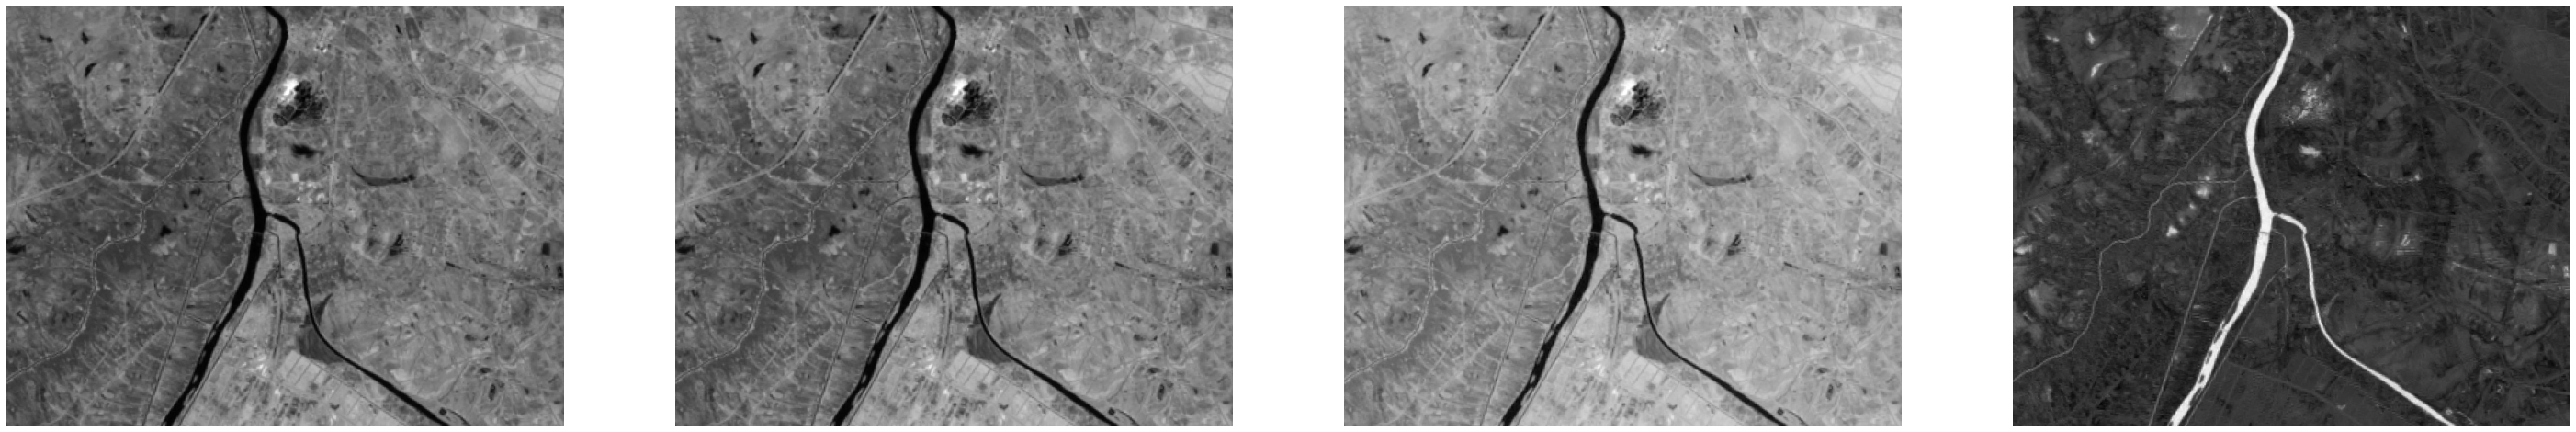

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (50,50), sharey='all')

for im, ax in zip([img, img_lg, img_gm, ndwi], axs):
  ax.imshow(im, cmap= 'gray')
  ax.axis('off')
plt.show()
plt.tight_layout()

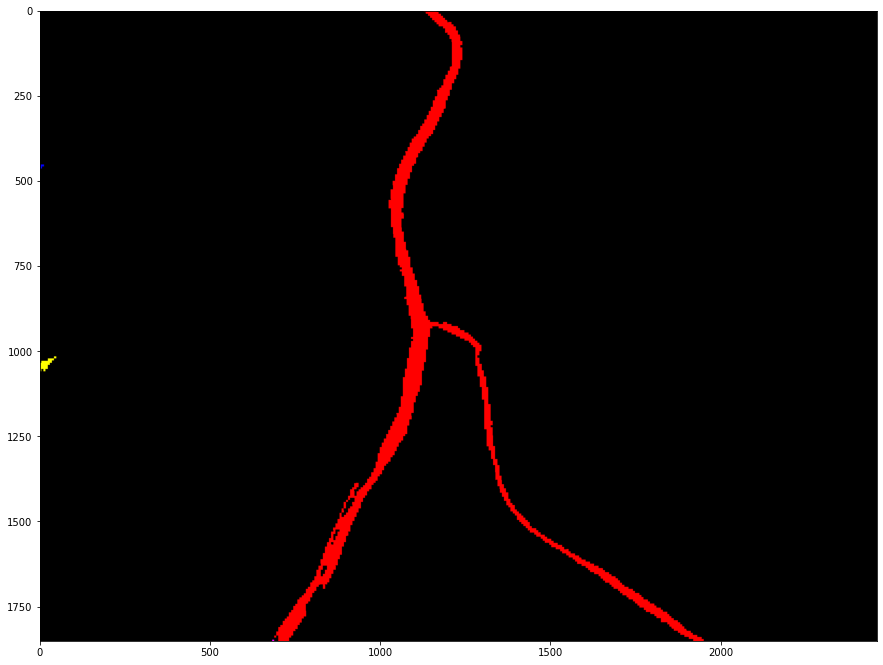

In [ ]:
mask_ndwi = ndwi >= .45
labels_clrd = clear_border(mask_ndwi)
river = mask_ndwi * ~labels_clrd
labels = label(river, background= 0)
lbl_overlay = label2rgb(labels, bg_label= 0)
plt.figure(figsize= (15,15))
plt.imshow(lbl_overlay)


## TIMESPAN SETUP FOR DATA ACQUISITION

In [4]:
# num_months = (end.year - start. year) * 12 + (end.month - start.month)
start = dt.date(1983,1,1)
end = dt.date(2012,3,31)
days = (end - start).days
months = days // 30
delta = (end - start) / months
print(delta)
marks = [(start + delta * jump).isoformat() for jump in range(months) ]

30 days, 0:08:05.393258


In [5]:
intervals = [(marks[i], marks[i+1]) for i in range(len(marks)-1)]
print(len(intervals))

355


In [6]:
interval_subset = intervals[:50]
interval_subset

[('1983-01-01', '1983-01-31'),
 ('1983-01-31', '1983-03-02'),
 ('1983-03-02', '1983-04-01'),
 ('1983-04-01', '1983-05-01'),
 ('1983-05-01', '1983-05-31'),
 ('1983-05-31', '1983-06-30'),
 ('1983-06-30', '1983-07-30'),
 ('1983-07-30', '1983-08-29'),
 ('1983-08-29', '1983-09-28'),
 ('1983-09-28', '1983-10-28'),
 ('1983-10-28', '1983-11-27'),
 ('1983-11-27', '1983-12-27'),
 ('1983-12-27', '1984-01-26'),
 ('1984-01-26', '1984-02-25'),
 ('1984-02-25', '1984-03-26'),
 ('1984-03-26', '1984-04-25'),
 ('1984-04-25', '1984-05-25'),
 ('1984-05-25', '1984-06-24'),
 ('1984-06-24', '1984-07-24'),
 ('1984-07-24', '1984-08-23'),
 ('1984-08-23', '1984-09-22'),
 ('1984-09-22', '1984-10-22'),
 ('1984-10-22', '1984-11-21'),
 ('1984-11-21', '1984-12-21'),
 ('1984-12-21', '1985-01-20'),
 ('1985-01-20', '1985-02-19'),
 ('1985-02-19', '1985-03-21'),
 ('1985-03-21', '1985-04-20'),
 ('1985-04-20', '1985-05-20'),
 ('1985-05-20', '1985-06-19'),
 ('1985-06-19', '1985-07-19'),
 ('1985-07-19', '1985-08-18'),
 ('1985-

## CREATE SAT PRODUCT REQUESTS

In [ ]:
data_collection

<DataCollection.LANDSAT_TM_L1: DataCollectionDefinition(
  api_id: landsat-tm-l1
  catalog_id: landsat-tm-l1
  wfs_id: DSS15
  service_url: https://services-uswest2.sentinel-hub.com
  collection_type: Landsat 4-5 TM
  sensor_type: TM
  processing_level: L1
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07')
  is_timeless: False
  has_cloud_coverage: True
)>

In [ ]:
# Define our key request parameters

def hubRequest(data_collection, evalscript, auxDct, bbox, size, interval, MimeType, identifier):
    return SentinelHubRequest(evalscript=evalscript, 
                                     input_data = [SentinelHubRequest.input_data(data_collection,
                                                                                time_interval = interval,
                                                                                other_args = auxDct)
                                                  ],

                                     responses= [SentinelHubRequest.output_response(identifier, MimeType)],

                                     bbox = bbox,
                                     size = size,
                                     config = config)
                             





In [ ]:
request_que = [hubRequest(data_collection, evalscript_LNDSAT_TM, auxDct, hindyaBBX, hindyaSize, data_folder, interval, MimeType, identifier)
               for interval in intervals]

request_que = [request.download_list[0] for request in request_que]
len(request_que)

355

In [ ]:
request_subset = [hubRequest(data_collection, evalscript_LNDSAT_TM, auxDct, hindyaBBX, hindyaSize, data_folder, interval, MimeType, identifier)
               for interval in interval_subset]

request_subset = [request.download_list[0] for request in request_subset]
len(request_subset)

50

In [ ]:
data_folder

'/content/drive/MyDrive/Colab Notebooks/data/LND4-5TM'

In [ ]:
hi_batch = SentinelHubDownloadClient(config = config).download(request_subset)
with gzip.open(data_folder + '/' + f"hindya_LND4_5TM0_hi.gz", "wb") as f:
    pickle.dump(hi_batch, f)
len(hi_batch)

50

In [ ]:
np.amax(hi_batch[40][...,2])

0.4543547

In [ ]:
elms = 40
segments = len(request_que) // elms
segments

8

In [ ]:
# segment the que
data_folder = '/content/drive/MyDrive/Colab Notebooks/data'

elms = 40
segments = len(request_que) // elms
for s in range(segments):
  data_batch = SentinelHubDownloadClient(config = config).download(request_que[s * elms: elms * (s + 1)])
  with gzip.open(data_folder + '/' + f"hindya_LND4_5TM{s}.gz", "wb") as f:
    pickle.dump(data_batch, f)
  del data_batch


In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/data'

In [ ]:
   
with gzip.open(data_folder + '/' + "hindya_LND4_5TM0.gz", 'rb') as file:
  batch = pickle.load(file)

len(batch), batch[0].shape     

40

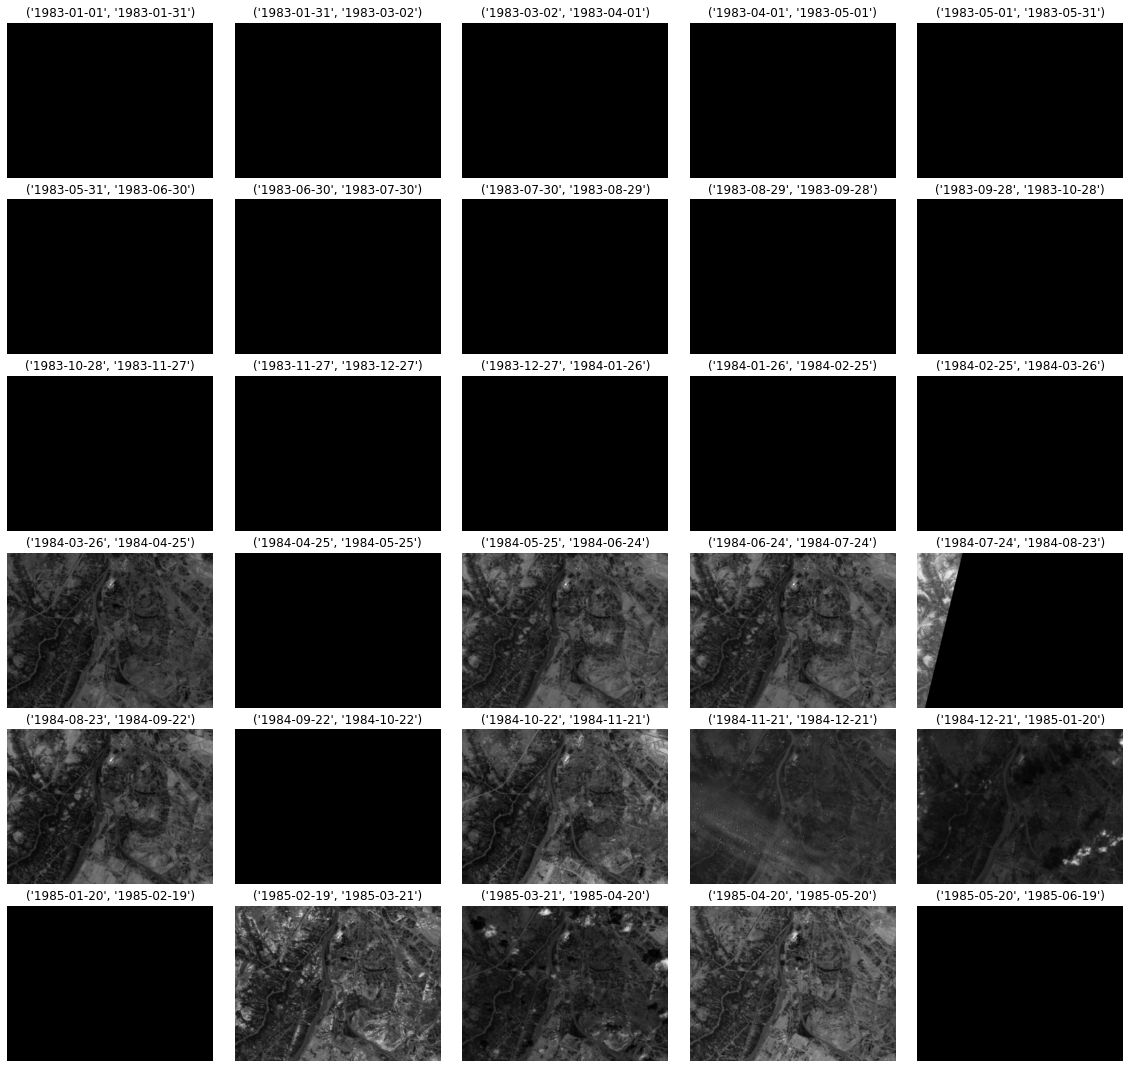

In [ ]:
#rcSize = len(batch)//4
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize = (20,20))
grid = ImageGrid(fig, 111, nrows_ncols= (6,5), axes_pad=0.3)

for qrt, img, intrv in zip(grid, batch, intervals[:40]):
    img = img[...,2]
    qrt.imshow(np.clip(img, 0, 1 ), cmap = 'gray')
    qrt.set_title(intrv)
    qrt.set_axis_off()
plt.show()

# LANDSAT 8 DATA: Feb 2013 - 31 dec 2015

Collection:
Landsat 8 L1


In [ ]:
# num_months = (end.year - start. year) * 12 + (end.month - start.month)
start = dt.date(2013,1,1)
end = dt.date(2015,12,31)
days = (end - start).days
months = days // 30
delta = (end - start) / months
print(delta)
marks = [(start + delta * jump).isoformat() for jump in range(months) ]

30 days, 9:20:00


In [ ]:
intervals = [(marks[i], marks[i+1]) for i in range(len(marks)-1)]
print(len(intervals))
print(intervals[:10])

35
[('2013-01-01', '2013-01-31'), ('2013-01-31', '2013-03-02'), ('2013-03-02', '2013-04-02'), ('2013-04-02', '2013-05-02'), ('2013-05-02', '2013-06-01'), ('2013-06-01', '2013-07-02'), ('2013-07-02', '2013-08-01'), ('2013-08-01', '2013-09-01'), ('2013-09-01', '2013-10-01'), ('2013-10-01', '2013-10-31')]


### EVALSCRIPT

In [ ]:
evalscript_LNDSAT_L8 = """
    //VERSION=3
    function setup() {
        return {

            input: [
          {
            bands: ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "dataMask"],
          }
        ],

            output: [
          {
            id: "landsat-ot-l1",
            bands: 7,
            sampleType: "FLOAT32",        
          },    
        ],

        mosaicking: "SIMPLE"
        }
    
    };

    function evaluatePixel(sample) {
        if (sample.dataMask == 1){
            return [
                sample.B02,
                sample.B03, 
                sample.B04, 
                sample.B05, 
                sample.B06, 
                sample.B07,
                sample.B08];
        }else {
        
        }
    };
"""

In [ ]:
data_collection_L8 = DataCollection.LANDSAT_OT_L1
identifier_L8 = "landsat-ot-l1"
singleInterval_L8 = ('2014-01-01', '2015-12-06')
auxDct_L8 = { "dataFilter":{"resolution":"HIGH", "mosaickingOrder": "leastCC", 'tiers': "TIER_1"}, 
              "processing": {"upsampling": "BICUBIC"}
              }

LNDL8_request = SentinelHubRequest(
                                 evalscript= evalscript_LNDSAT_L8, 
                                 input_data = [SentinelHubRequest.input_data(data_collection_L8,
                                                                            time_interval = singleInterval_L8, 
                                                                            other_args = auxDct_L8
                                                                           )
                                              ],
                                 
                                 responses= [SentinelHubRequest.output_response(identifier_L8, MimeType)],
                                 
                                 bbox = hindyaBBX,
                                 size = hindyaSize,
                                 config = config)

In [ ]:
test= LNDL8_request.get_data(save_data= False)
len(test), test[0].shape

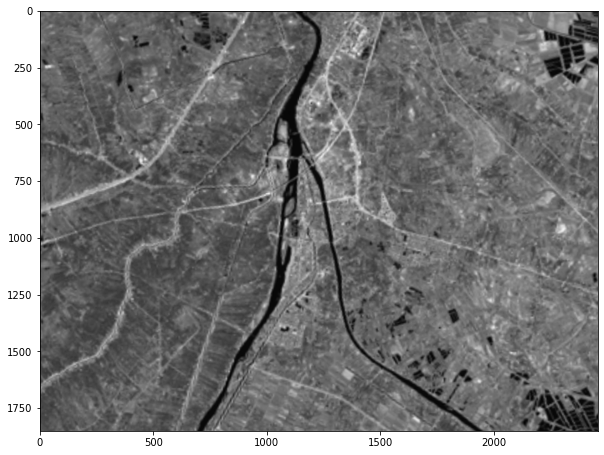

In [ ]:
mss = test[0][...,5]
plt.figure(figsize= (10,10))
plt.imshow(mss, cmap='gray')

### PLACE LANDSAT L8 ORDER

In [ ]:
data_folder = "/content/drive/MyDrive/Colab Notebooks/data/"


In [ ]:
request_que = [hubRequest(data_collection_L8, evalscript_LNDSAT_L8, auxDct_L8, hindyaBBX, hindyaSize, interval, MimeType, identifier_L8)
               for interval in intervals]

request_que = [request.download_list[0] for request in request_que]
len(request_que)

35

In [ ]:
chunks = np.array_split(range(35), 4)
chunks

[array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([27, 28, 29, 30, 31, 32, 33, 34])]

In [ ]:
for indx, chunk in enumerate(chunks):
  start, end = (min(chunk), max(chunk))
  data_batch = SentinelHubDownloadClient(config = config).download(request_que[start: end])
  with gzip.open(data_folder + f"hindya_LND8_OTI{indx}.gz", "wb") as f:
    pickle.dump(data_batch, f)
  del data_batch

### READ L8 BATCH

In [ ]:
data_file = "hindya_LND8_OTI0.gz"

In [ ]:
with gzip.open(data_folder + data_file, "rb") as f:
    batch = pickle.load(f)
len(batch)

8

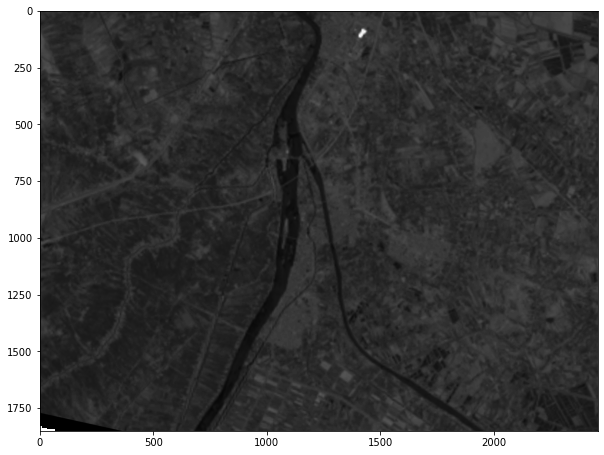

In [ ]:
plt.figure(figsize= (10,10))
plt.imshow(batch[5][...,4],cmap= 'gray')

# SENTINEL-2 DATA: Jan 2016 - 31 Sept 2021
Collection: sentinel-2-l1c

In [ ]:
# num_months = (end.year - start. year) * 12 + (end.month - start.month)
start = dt.date(2016,1,1)
end = dt.date(2021,9,30)
days = (end - start).days
months = days // 30
delta = (end - start) / months
print(delta)
marks = [(start + delta * jump).isoformat() for jump in range(months) ]

30 days, 10:05:13.043478


In [ ]:
intervals = [(marks[i], marks[i+1]) for i in range(len(marks)-1)]
print(len(intervals))
print(intervals[:10])

68
[('2016-01-01', '2016-01-31'), ('2016-01-31', '2016-03-01'), ('2016-03-01', '2016-04-01'), ('2016-04-01', '2016-05-01'), ('2016-05-01', '2016-06-01'), ('2016-06-01', '2016-07-01'), ('2016-07-01', '2016-07-31'), ('2016-07-31', '2016-08-31'), ('2016-08-31', '2016-09-30'), ('2016-09-30', '2016-10-31')]


### EVALSCRIPT

In [ ]:
evalscript_Sent2 = """
    //VERSION=3
    function setup() {
        return {

            input: [
          {
            bands: ["B02", "B03", "B04", "B08", "B11", "dataMask"],
          }
        ],

            output: [
          {
            id: "sentinel-2-l1c",
            bands: 5,
            sampleType: "FLOAT32",        
          },    
        ],

        mosaicking: "SIMPLE"
        }
    
    };

    function evaluatePixel(sample) {
        if (sample.dataMask == 1){
            return [
                sample.B02,
                sample.B03, 
                sample.B04,  
                sample.B08,
                sample.B11];
        }else {
        
        }
    };
"""

In [ ]:
data_collection_Sent2 = DataCollection.SENTINEL2_L1C
identifier_Sent2 = "sentinel-2-l1c"
singleInterval_Sent2 = ('2016-01-01', '2016-12-06')
auxDct_Sent2 = { "dataFilter":{"resolution":"HIGH", "mosaickingOrder": "leastCC"}, 
              "processing": {"upsampling": "BICUBIC"}
              }

Sent2_request = SentinelHubRequest(
                                 evalscript= evalscript_Sent2, 
                                 input_data = [SentinelHubRequest.input_data(data_collection_Sent2,
                                                                            time_interval = singleInterval_Sent2, 
                                                                            other_args = auxDct_Sent2
                                                                           )
                                              ],
                                 
                                 responses= [SentinelHubRequest.output_response(identifier_Sent2, MimeType)],
                                 
                                 bbox = hindyaBBX,
                                 size = hindyaSize,
                                 config = config)

In [ ]:
test = Sent2_request.get_data(save_data= False)
len(test), test[0].shape, np.amin(test[0]), np.amax(test[0])

(1, (1851, 2459, 5), 0.0127, 0.5209)

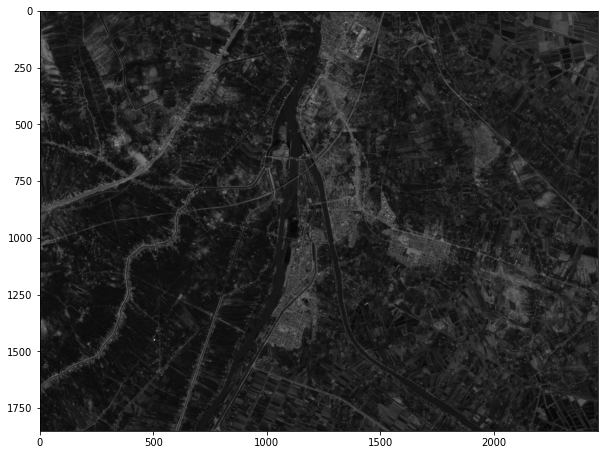

In [ ]:
img = test[0][...,0]
plt.figure(figsize= (10,10))
plt.imshow(img, cmap='gray')

In [ ]:
request_que = [hubRequest(data_collection_Sent2, evalscript_Sent2, auxDct_Sent2, hindyaBBX, hindyaSize, interval, MimeType, identifier_Sent2)
               for interval in intervals]

request_que = [request.download_list[0] for request in request_que]
len(request_que)

68

In [ ]:
limit = len(request_que)
chunks = np.array_split(range(limit), 3)
chunks

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45]),
 array([46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
        63, 64, 65, 66, 67])]

In [ ]:
for indx, chunk in enumerate(chunks):
  start, end = (min(chunk), max(chunk))
  data_batch = SentinelHubDownloadClient(config = config).download(request_que[start: end])
  with gzip.open(data_folder + f"hindya_SENT2_{indx}.gz", "wb") as f:
    pickle.dump(data_batch, f)
  del data_batch

In [ ]:
start, end = (min(chunks[-1]), max(chunks[-1]))
start, end

(46, 67)

In [ ]:
start, end = (min(chunks[-1]), max(chunks[-1]))
data_batch = SentinelHubDownloadClient(config = config).download(request_que[start: end])
with gzip.open(data_folder + f"hindya_SENT2_2.gz", "wb") as f:
  pickle.dump(data_batch, f)

/usr/local/lib/python3.7/dist-packages/sentinelhub/download/sentinelhub_client.py:71: SHRateLimitWarning: Download rate limit hit
  warnings.warn('Download rate limit hit', category=SHRateLimitWarning)
/usr/local/lib/python3.7/dist-packages/sentinelhub/download/sentinelhub_client.py:71: SHRateLimitWarning: Download rate limit hit
  warnings.warn('Download rate limit hit', category=SHRateLimitWarning)
/usr/local/lib/python3.7/dist-packages/sentinelhub/download/sentinelhub_client.py:71: SHRateLimitWarning: Download rate limit hit
  warnings.warn('Download rate limit hit', category=SHRateLimitWarning)
/usr/local/lib/python3.7/dist-packages/sentinelhub/download/sentinelhub_client.py:71: SHRateLimitWarning: Download rate limit hit
  warnings.warn('Download rate limit hit', category=SHRateLimitWarning)
/usr/local/lib/python3.7/dist-packages/sentinelhub/download/sentinelhub_client.py:71: SHRateLimitWarning: Download rate limit hit
  warnings.warn('Download rate limit hit', category=SHRateLimi

## SAVE DATA

In [ ]:
data_batch = SentinelHubDownloadClient(config = config).download(request_que)
with gzip.open(data_folder + f"hindya_SENT2.gz", "wb") as f:
  pickle.dump(data_batch, f)